# Step 1 - Frame Dividing Part

#### Install Opencv for Frame Extraction

In [1]:
pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


#### Importing Libraries CV2 and OS

In [2]:
import cv2
import os

#### Function to Extract Frames

In [3]:
from automatic_pipeline.extract_frames import extract_frames

#### Crop black margins

In [4]:
from automatic_pipeline.crop_black_margins import crop_black_margins

# Step 2 - Extracting Key points

#### Install mediapipe

In [5]:
pip install mediapipe


#### Detect Keypoints - Annotate the Frames

In [6]:
from automatic_pipeline.annotate_frames import detect_keypoints

#### Extract 2D Key Point Data into Json

In [7]:
from automatic_pipeline.extract_2d_keypoint import extract_2d_keypoints

#### Normalize the data

- According to hip dne when extracting 2D keypoints

# Step 3 - Feature Extraction using Media Pipe

#### Get Angles from Keypoints

In [8]:
from automatic_pipeline.extract_joint_angles import extract_joint_angles

#### Extract velocities

In [9]:
from automatic_pipeline.extract_velocities import extract_velocity_side_view

# Step 4 - Creating Dataset

#### Install Pandas

In [10]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


#### Creating Dataset for GRU regression - This will be used in Automatic pipeline

# Automatic Pipeline function

In [11]:
import os
import cv2
import json
import csv
import shutil
from datetime import datetime

# ======================= #
# ==== CONFIGURATION ==== #
# ======================= #

# Hardcoded output paths for consistency
FRAMES_ROOT = "Output/frames"
KEYPOINTS_ROOT = "Output/keypoints"
ANNOTATIONS_ROOT = "Output/annotations"
LOG_FILE = "Output/processing_log.txt"
CENTRAL_INDEX_FILE = "Output/central_index.csv"


# Features to extract from the video

ANGLES_ROOT = "Output/angles"
VELOCITIES_ROOT = "Output/velocities"
PHASE_ROOT = "Output/phase_data"

# Create all required output folders at startup
for path in [FRAMES_ROOT, KEYPOINTS_ROOT, ANNOTATIONS_ROOT, ANGLES_ROOT,VELOCITIES_ROOT,PHASE_ROOT, os.path.dirname(LOG_FILE)]:
    os.makedirs(path, exist_ok=True)

# =============================== #
# ==== UTILITY HELPER FUNCS ==== #
# =============================== #

# This function retrieves all video files from the specified root folder and its subdirectories.
## It supports multiple file extensions (e.g., .mp4, .mov) and returns a list of full paths.
def get_all_video_paths(root_folder, extensions=(".mp4", ".MOV")):
    video_paths = []
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower().endswith(extensions):
                video_paths.append(os.path.join(dirpath, file))
    return video_paths


# This function generates a relative path for a video file based on the root input folder.
def get_relative_path(video_path, root_folder):
    return os.path.relpath(video_path, root_folder)

# This function builds output paths for frames, keypoints, annotations, and metadata based on the video path.
# It uses the relative path to create a consistent structure under the defined output folders.
def build_output_paths(video_path, root_input_folder):
    relative_path = get_relative_path(video_path, root_input_folder)
    base = os.path.splitext(relative_path)[0]
    return {
        "frames": os.path.join(FRAMES_ROOT, base),
        "keypoints": os.path.join(KEYPOINTS_ROOT, base),
        "annotations": os.path.join(ANNOTATIONS_ROOT, base),
        "metadata": os.path.join(KEYPOINTS_ROOT, base, "metadata.json"),
        "angles": os.path.join(ANGLES_ROOT, base),  #features
        "velocities": os.path.join(VELOCITIES_ROOT, base),  # velocities
        "phase_data": os.path.join(PHASE_ROOT, base)  # phase data
    }

# This function checks if a video has already been processed by looking for the metadata file.
# If the metadata file exists, it indicates that the video has been processed.
def has_been_processed(paths):
    return os.path.exists(paths["metadata"])

# This function logs messages to a log file and prints them to the console.
# It includes a timestamp for each message.
def log_message(message):
    timestamp = f"{datetime.now()} - {message}"
    os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)
    with open(LOG_FILE, "a", encoding="utf-8") as log_file:
        log_file.write(timestamp + "\n")
    print(timestamp)

# This function saves metadata about the processed video to a JSON file.
# It includes the video path, processing time, and paths to frames and keypoints.
def save_metadata(metadata_path, data):
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

# This function updates a central index CSV file with metadata about processed videos.
# It appends a new row with the video path, frame folder, keypoints folder, annotation folder, and processing time.
def update_central_index(index_file, row):
    os.makedirs(os.path.dirname(index_file), exist_ok=True)
    file_exists = os.path.exists(index_file)
    with open(index_file, "a", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=row.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)

# ===================================== #
# ==== MAIN VIDEO PROCESSOR FUNC  ==== #
# ===================================== #

def process_all_videos(root_input_folder):
    """
    Main function to process all videos in the specified root input folder.
    It extracts frames, detects keypoints, and saves metadata.
    """
    
    # Get all video paths from the root input folder
    videos = get_all_video_paths(root_input_folder)
    # If no videos found, log and exit
    log_message(f"🎬 Found {len(videos)} videos under '{root_input_folder}'")

    # If no videos found, exit early
    for video_path in videos:
        paths = build_output_paths(video_path, root_input_folder)
        if has_been_processed(paths):
            log_message(f"⏭️ Skipping already processed: {video_path}")
            continue

        # Create required output folders
        for key in ["frames", "keypoints", "annotations", "angles","velocities","phase_data"]:
            os.makedirs(paths[key], exist_ok=True)

        try:
            # ====== MAIN PIPELINE STEPS ======
            # ====== Adjust these steps as needed ======
            


            # STEP 1: Extract frames from the video
            extract_frames(video_path, paths["frames"])

            # STEP 1.1: Crop black margins on the extracted frames
            cropped_frames_folder = paths["frames"] + "_cropped"
            crop_black_margins(paths["frames"], cropped_frames_folder)

            # Delete original frames folder with un-cropped frames
            shutil.rmtree(paths["frames"])

            # Rename cropped folder to original frames folder name
            os.rename(cropped_frames_folder, paths["frames"])

            # # STEP 2: Detect keypoints in the frames
            # detect_keypoints(paths["frames"], paths["annotations"])  # ok not problem
            
            # STEP 3: Extract 2D keypoints from the annotated frames
            extract_2d_keypoints(paths["frames"], os.path.join(paths["keypoints"], "keypoints.json"))  # ok
            
            # STEP 4: Extract joint angles from keypoints
            extract_joint_angles(os.path.join(paths["keypoints"], "keypoints.json"), os.path.join(paths["angles"], "joint_angles.json"))  # STEP 4
            
            # # STEP 5: Extract velocities for side view
            extract_velocity_side_view(os.path.join(paths["keypoints"], "keypoints.json"),os.path.join(paths["velocities"], "velocities.json"))

            # ====== End of processing steps ======
            
            # ====== Save metadata ======
            metadata = {
                "video": video_path,
                "processed_at": str(datetime.now()),
                "frames_folder": paths["frames"],
                "keypoints_json": os.path.join(paths["keypoints"], "keypoints.json")
            }
            save_metadata(paths["metadata"], metadata)

            # ====== Update tracking CSV ======
            update_central_index(CENTRAL_INDEX_FILE, {
                "video_path": video_path,
                "frames_folder": paths["frames"],
                "keypoints_folder": paths["keypoints"],
                "annotation_folder": paths["annotations"],
                "processed_at": metadata["processed_at"]
            })

            log_message(f"✅ Processed: {video_path}")

        except Exception as e:
            log_message(f"❌ Error processing {video_path}: {str(e)}")


In [13]:
process_all_videos("Source")

2025-07-04 21:01:58.455227 - 🎬 Found 30 videos under 'Source'
Video: Source\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view.mp4, FPS: 30
 Extracted 230 frames from Source\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view.mp4
✅ Cropped images saved to: Output/frames\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view_cropped
✅ 2D normalized keypoints extracted and saved to Output/keypoints\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\keypoints.json
✅ Saved joint angles to Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\joint_angles.json
✅ Saved side view velocities (in m/s) to Output/velocities\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\velocities.json
2025-07-04 21:03:03.173464 - ✅ Processed: Source\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view.mp4
Video: Source\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_side_view.mp4, FPS: 30
 Extracted 231 frames from Source\Pla

# Dataset Creation

#### Find Files for the json file (Front ,Side,Top),velocities,phase and Verify and return quintuplet

In [14]:
import os
from collections import defaultdict

# This function finds complete sets (quintuplets) containing:
# - joint angles from 3 views (front, side, top)
# - corresponding velocity (from side view path)
# - corresponding phase data (from front view path)
def find_joint_angle_velocity_phase_quintuplets(angle_root, velocity_root, phase_root):
    # Dictionary to group angle files per set folder (e.g., Set_01), with keys 'front', 'side', 'top'
    triplet_groups = defaultdict(dict)

    print("🔍 Scanning for joint angle files...\n")

    # Step 1: Walk through all directories under angle_root to find joint_angles.json files
    for root, dirs, files in os.walk(angle_root):
        if "joint_angles.json" in files:
            view_type = None

            # Identify view type from folder name
            if "front_view" in root:
                view_type = "front"
            elif "side_view" in root:
                view_type = "side"
            elif "top_view" in root:
                view_type = "top"

            if view_type:
                # Build full path to the joint_angles.json file
                path_to_file = os.path.join(root, "joint_angles.json")

                # Get relative path from angle_root to current view folder
                relative_path = os.path.relpath(root, angle_root)

                # Extract the parent directory (set folder) to group views together
                set_folder = os.path.dirname(relative_path)

                # Store file path under the appropriate view type for that set
                triplet_groups[set_folder][view_type] = path_to_file

                print(f"📥 Found {view_type} angle: {path_to_file}")

    print("\n🔍 Constructing quintuplets...\n")

    # List to store all complete quintuplets
    quintuplets = []

    # Step 2: For each set folder that has all 3 views (front, side, top)
    for set_folder, views in triplet_groups.items():
        if all(v in views for v in ["front", "side", "top"]):
            # Use side view path to compute expected velocity file path
            side_angle_path = views["side"]
            velocity_path = side_angle_path.replace(angle_root, velocity_root).replace("joint_angles.json", "velocities.json")

            # Use front view path to compute expected phase file path
            front_angle_path = views["front"]
            phase_path = front_angle_path.replace(angle_root, phase_root).replace("joint_angles.json", "phase.json")

            print(f"\n📂 Set Folder: {set_folder}")
            print(f"🧭 Checking velocity: {velocity_path}")
            print(f"🧭 Checking phase:    {phase_path}")

            # Check if both velocity and phase files exist
            velocity_exists = os.path.exists(velocity_path)
            phase_exists = os.path.exists(phase_path)

            if velocity_exists and phase_exists:
                print(f"✅ All files present for set: {set_folder}")
                # Append the tuple of 5 paths: front, side, top, velocity, phase
                quintuplets.append((views["front"], views["side"], views["top"], velocity_path, phase_path))
            else:
                # Warn about missing files
                if not velocity_exists:
                    print(f"⚠️ Missing velocity file for set: {set_folder}\n    → Expected at: {velocity_path}")
                if not phase_exists:
                    print(f"⚠️ Missing phase file for set: {set_folder}\n    → Expected at: {phase_path}")

    print(f"\n✅ Found {len(quintuplets)} complete quintuplets (angles + velocity + phase).")
    return quintuplets


In [21]:
# Call the function to find complete sets of:
# - front_view joint_angles.json
# - side_view joint_angles.json
# - top_view joint_angles.json
# - velocities.json (derived from side view path)
# - phase.json (derived from front view path)
quintuplets = find_joint_angle_velocity_phase_quintuplets(
    angle_root="Output/angles",          # Root folder containing joint angle files
    velocity_root="Output/velocities",   # Root folder containing velocity files
    phase_root="Output/phase_data"       # Root folder containing phase label files
)

# Loop through each quintuplet (complete set of 5 files)
for idx, (front_path, side_path, top_path, velocity_path, phase_path) in enumerate(quintuplets):
    print(f"\n▶️ Set {idx+1}")  # Print the set number
    print("Front   :", front_path)      # Path to front_view joint_angles.json
    print("Side    :", side_path)       # Path to side_view joint_angles.json
    print("Top     :", top_path)        # Path to top_view joint_angles.json
    print("Velocity:", velocity_path)   # Path to velocities.json (side view)
    print("Phase   :", phase_path)      # Path to phase.json (front view)
    print("---")  # Separator line between sets


🔍 Scanning for joint angle files...

📥 Found front angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_top_view\joint_angles.json
📥 Found front angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_top_view\joint_angles.json
📥 Found front angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\Player03_FCJ_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\Player03_FCJ_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\

#### Genarate the Sequence Combinig quituplet files

In [22]:
import json
from collections import Counter

def process_joint_angle_velocity_phase_triplet(
    front_path, side_path, top_path, velocity_path, phase_path, seq_len=10
):
    # 🔹 Load joint angle data for each view (front, side, top)
    with open(front_path, "r") as f:
        front_angles = json.load(f)

    with open(side_path, "r") as f:
        side_angles = json.load(f)

    with open(top_path, "r") as f:
        top_angles = json.load(f)

    # 🔹 Load velocity data (usually derived from side view)
    with open(velocity_path, "r") as f:
        velocities = json.load(f)

    # 🔹 Load phase label data (from front view path usually)
    with open(phase_path, "r") as f:
        phase_data = json.load(f)

    # 🔹 Get a sorted list of frame names (e.g., frame_0001.jpg, frame_0002.jpg, ...)
    # Assumes that all views and velocity files are aligned by frame names
    frames = sorted(front_angles.keys())

    # 🔹 Create a mapping from each frame name to its corresponding phase label
    frame_phase_map = {}
    for phase_entry in phase_data["phases"]:
        phase_label = phase_entry["phase"]
        start = phase_entry["start_frame"]
        end = phase_entry["end_frame"]
        # Fill in the map with phase label for all frames in the range
        for i in range(start, end + 1):
            frame_name = f"frame_{i:04d}.jpg"
            frame_phase_map[frame_name] = phase_label

    # 🔹 List to collect final sequence chunks
    sequences = []

    # 🔹 Use sliding window approach to extract fixed-length sequences
    for start_idx in range(len(frames) - seq_len + 1):
        # Get a list of consecutive frame names in the current window
        seq_frames = frames[start_idx : start_idx + seq_len]

        # 🔸 Extract joint angles and velocity data for each frame in the sequence
        angles_front_seq = [front_angles.get(f, {}) for f in seq_frames]
        angles_side_seq = [side_angles.get(f, {}) for f in seq_frames]
        angles_top_seq = [top_angles.get(f, {}) for f in seq_frames]
        velocities_seq = [velocities.get(f, {}) for f in seq_frames]

        # 🔸 Get phase labels for each frame in the sequence
        phase_labels = [frame_phase_map.get(f, "unknown") for f in seq_frames]

        # 🔸 Use majority vote to decide the phase label for the whole sequence
        phase_counter = Counter(phase_labels)
        majority_phase = phase_counter.most_common(1)[0][0]

        # 🔹 Collect all data into a dictionary
        sequence_data = {
            "frames": seq_frames,
            "angles_front": angles_front_seq,
            "angles_side": angles_side_seq,
            "angles_top": angles_top_seq,
            "velocities": velocities_seq,
            "phase": majority_phase
        }

        # 🔹 Append the sequence to the list
        sequences.append(sequence_data)

    # 🔚 Return all extracted sequences
    return sequences


#### Create Dataset -Feedback Genaration

In [23]:
def generate_feedback_for_sequence(sequence):
    feedback = {}
    phase = sequence["phase"]
    angles = sequence["angles_side"]  # mostly joint angles from side view
    velocities = sequence["velocities"]  # side view velocities
    top_angles = sequence["angles_top"]  # top view (symmetry, etc.)

    # Calculate average values over the sequence
    def avg(values, key):
        vals = [f.get(key) for f in values if f.get(key) is not None]
        return sum(vals) / len(vals) if vals else None

    # -------------------- JOINT ANGLE FEEDBACK --------------------
    avg_elbow = avg(angles, "elbow_angle")
    avg_knee = avg(angles, "knee_angle")
    avg_hip = avg(angles, "hip_angle")
    avg_back = avg(angles, "back_angle")

    # -------------------- VELOCITY FEEDBACK --------------------
    avg_knee_v = avg(velocities, "knee_velocity")
    avg_hip_v = avg(velocities, "hip_velocity")

    # -------------------- SYMMETRY FEEDBACK --------------------
    shoulder_sym = avg(top_angles, "shoulder_symmetry")
    hip_sym = avg(top_angles, "hip_symmetry")

    # ================= PHASE-SPECIFIC THRESHOLDS =================
    if phase == "start":
        if avg_back and avg_back < 160:
            feedback["back"] = "Straighten your back more in the setup."
        if avg_knee and avg_knee > 120:
            feedback["knee"] = "Reduce knee bend slightly during the setup."
    elif phase == "first_pull":
        if avg_back and avg_back < 155:
            feedback["back"] = "Maintain a stronger back angle in first pull."
        if avg_knee and avg_knee > 130:
            feedback["knee"] = "Pull with legs more, reduce excessive knee bend."
        if avg_hip and avg_hip < 120:
            feedback["hip"] = "Open hips more during first pull."
        if avg_knee_v and avg_knee_v < 0.6:
            feedback["knee_velocity"] = "Pull more explosively (increase knee speed)."
    elif phase == "second_pull":
        if avg_hip_v and avg_hip_v < 1.0:
            feedback["hip_velocity"] = "Explode harder with hips in second pull."
        if avg_knee_v and avg_knee_v < 1.0:
            feedback["knee_velocity"] = "Drive harder with legs."
        if avg_elbow and avg_elbow > 170:
            feedback["elbow"] = "Keep elbows higher and outside in second pull."
    elif phase == "turnover":
        if avg_elbow and avg_elbow < 90:
            feedback["elbow"] = "Pull elbows under faster in turnover."
    elif phase == "catch":
        if avg_back and avg_back < 150:
            feedback["back"] = "Stay tighter in the catch position."
        if avg_knee and avg_knee < 80:
            feedback["knee"] = "Squat deeper to secure catch."
    elif phase == "recovery":
        if avg_back and avg_back < 155:
            feedback["back"] = "Maintain back angle while standing up."
        if avg_knee and avg_knee > 130:
            feedback["knee"] = "Drive knees out more during recovery."

    # -------------------- SYMMETRY FEEDBACK --------------------
    if shoulder_sym and shoulder_sym > 15:
        feedback["shoulder_symmetry"] = "Balance shoulders; one side is dropping."
    if hip_sym and hip_sym > 15:
        feedback["hip_symmetry"] = "Correct hip alignment during lift."

    return feedback


#### Automatic Pipeline - Dataset Creation

In [24]:
import os
import json
from collections import Counter

# ==========================================
# 🔹 STEP 1: Find All Valid Data Sets
# Look for matching (front, side, top) joint angle files + velocity + phase label
# ==========================================

quintuplets = find_joint_angle_velocity_phase_quintuplets(
    angle_root="Output/angles",
    velocity_root="Output/velocities",
    phase_root="Output/phase_data"
)

# Store all feedback results for all videos
all_feedback = []

# ==========================================
# 🔹 STEP 2: Process Each Data Set (1 per video or session)
# ==========================================

for idx, (front_path, side_path, top_path, velocity_path, phase_path) in enumerate(quintuplets):
    print(f"\n▶️ Set {idx+1}/{len(quintuplets)}")
    print("Front   :", front_path)
    print("Side    :", side_path)
    print("Top     :", top_path)
    print("Velocity:", velocity_path)
    print("Phase   :", phase_path)
    print("---")

    # ==========================================
    # 🔹 STEP 3: Create Sequences (Sliding Window)
    # Each sequence = 10 frames of joint angle + velocity + phase
    # ==========================================
    sequences = process_joint_angle_velocity_phase_triplet(
        front_path, side_path, top_path, velocity_path, phase_path, seq_len=10
    )

    if sequences:  # Only print sample if there's data
        first_seq = sequences[0]
        print("First sequence frames:", first_seq["frames"])
        print("Phase label:", first_seq["phase"])
        print("Sample front angles:", first_seq["angles_front"][0])
        print("Sample velocities:", first_seq["velocities"][0])

    print(f"📦 Found {len(sequences)} sequences")

    # ==========================================
    # 🔹 STEP 4: Generate Feedback Per Sequence
    # Output will be phase-specific feedback (based on joint angles, velocity)
    # ==========================================
    for seq_idx, seq in enumerate(sequences):
        feedback = generate_feedback_for_sequence(seq)
        all_feedback.append({
            "set_index": idx,
            "sequence_index": seq_idx,
            "phase": seq["phase"],
            "frames": seq["frames"],
            "feedback": feedback
        })

# ==========================================
# 🔹 STEP 5: Save All Feedback to JSON
# ==========================================

output_path = "feedback_output.json"
with open(output_path, "w") as f:
    json.dump(all_feedback, f, indent=4)

print(f"\n✅ All feedback saved to: {output_path}")


🔍 Scanning for joint angle files...

📥 Found front angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_top_view\joint_angles.json
📥 Found front angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_top_view\joint_angles.json
📥 Found front angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\Player03_FCJ_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\Player03_FCJ_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\

In [25]:
create_regression_dataset_from_folder_auto_tagged(
    angles_root="D:/AI Model/Output/angles",
    output_path="regression_dataset_all.npz",
    metadata_log_path="regression_metadata_log_all.json",
    seq_len=20
)


NameError: name 'create_regression_dataset_from_folder_auto_tagged' is not defined

# Step 5 - Model Architecture Designing and Training

#### Necessory Modules install

##### Sklearn Install

In [ ]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


##### Tenserflow install

In [ ]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


#### GRU Regression Model Train

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

data = np.load("feedback_dataset.npz")
X = data["X"]
y = data["y"]

# Same model training script as before


# === Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Define GRU regression model ===
def build_gru_regression_model(input_shape):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(y.shape[1], activation='linear'))  # Linear output for regression
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# === Build model ===
input_shape = (X_train.shape[1], X_train.shape[2])  # (seq_len, features)
model = build_gru_regression_model(input_shape)

# === Train model ===
history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_val, y_val))

# === Save model ===
model.save("gru_posture_model_snatch_regression.h5")

# === Print training history ===
print("✅ Training complete!")
print(history.history)


d:\AI Research\AI Model\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.8404 - mean_absolute_error: 0.9098 - val_loss: 0.3678 - val_mean_absolute_error: 0.6059
Epoch 2/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2453 - mean_absolute_error: 0.4788 - val_loss: 0.0170 - val_mean_absolute_error: 0.1039
Epoch 3/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - mean_absolute_error: 0.0678 - val_loss: 0.0105 - val_mean_absolute_error: 0.0391
Epoch 4/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mean_absolute_error: 0.0471 - val_loss: 0.0091 - val_mean_absolute_error: 0.0243
Epoch 5/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mean_absolute_error: 0.0493 - val_loss: 0.0090 - val_mean_absolute_error: 0.0165
Epoch 6/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_absolute_error: 0.0453 - val_loss: 0.0090 - val_mean_absolute_error: 0.0197
Epoch 7/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mean_absolute_error: 0.0477 - val_los

✅ Training complete!
{'loss': [0.7006509304046631, 0.15529485046863556, 0.010963918641209602, 0.00849249679595232, 0.008419707417488098, 0.00855683721601963, 0.008107081055641174, 0.008085537701845169, 0.007793399039655924, 0.008693908341228962, 0.008227741345763206, 0.008294390514492989, 0.007854928262531757, 0.007949717342853546, 0.008216806687414646, 0.008034245111048222, 0.008161019533872604, 0.008119048550724983, 0.008001438342034817, 0.007955367676913738, 0.008243639022111893, 0.007878956384956837, 0.007805974222719669, 0.008059727028012276, 0.008156116120517254, 0.008207336999475956, 0.008065554313361645, 0.008256865665316582, 0.0076642027124762535, 0.007501089014112949, 0.007882283069193363, 0.008412804454565048, 0.007804792374372482, 0.008375248871743679, 0.008174046874046326, 0.00843753945082426, 0.0077067487873137, 0.008449720218777657, 0.008038623258471489, 0.008120588958263397, 0.007723698858171701, 0.008221495896577835, 0.007714192382991314, 0.00783914141356945, 0.0080655

#### Plot the Metrics

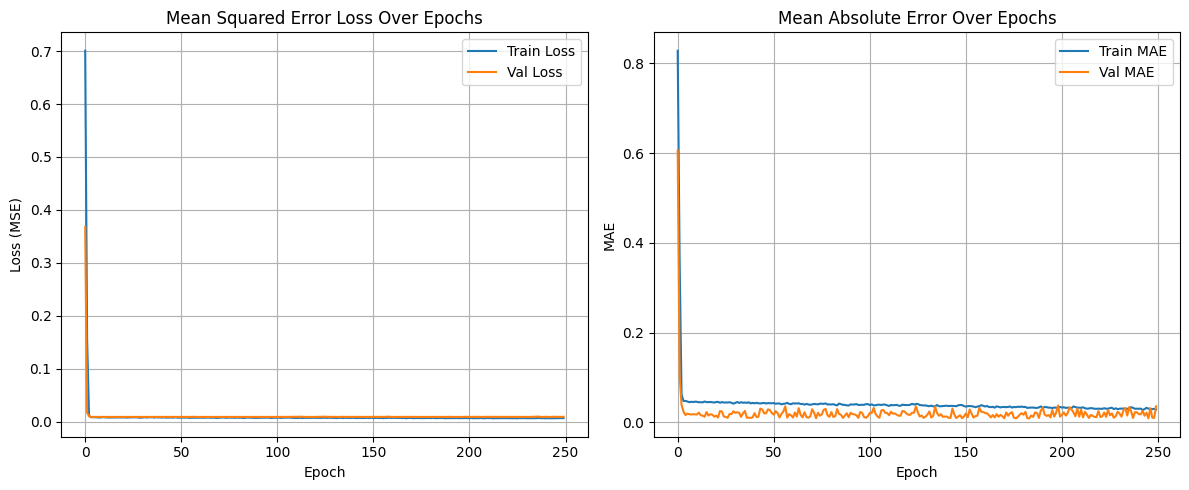

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Mean Squared Error Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history["mean_absolute_error"], label="Train MAE")
plt.plot(history.history["val_mean_absolute_error"], label="Val MAE")
plt.title("Mean Absolute Error Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


##### Metrics

In [ ]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"📉 Validation Loss (MSE): {val_loss:.4f}")
print(f"📈 Validation MAE: {val_mae:.4f}")


📉 Validation Loss (MSE): 0.0093
📈 Validation MAE: 0.0359


## Using Model

#### Load Saved Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("gru_posture_model_snatch_regression.h5")


In [ ]:
data = np.load("regression_dataset_snatch.npz")
X_test = data["X"]
y_test = data["y"]  # optional, if you want to compare

# Predict for all samples
y_pred = model.predict(X_test)

# Example: Compare first prediction with ground truth
print("Predicted:", y_pred[0])
print("Actual   :", y_test[0])


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: [ 0.04028483  3.4688342  -0.9196923   1.7480456  -0.21574661]
Actual   : [-40.83803125   4.00943148  84.4181457   97.9865693   -1.17797459]
